# Deep Learning for Computer Vision:  Assignment 2


## Computer Science: COMS W 4995 004


## Due: February 27, 2018

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units affects the solution.

e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisey as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 85%, e=10%, f=5%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [129]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's make up some noisy XOR data.

In [130]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,-0.055408,0.897739,1.0
1,0.999787,1.097978,0.0
2,0.975327,0.632464,0.0
3,-0.003821,0.084507,0.0
4,0.793413,0.247440,1.0


Let's message this data into a numpy format.

In [131]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [132]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

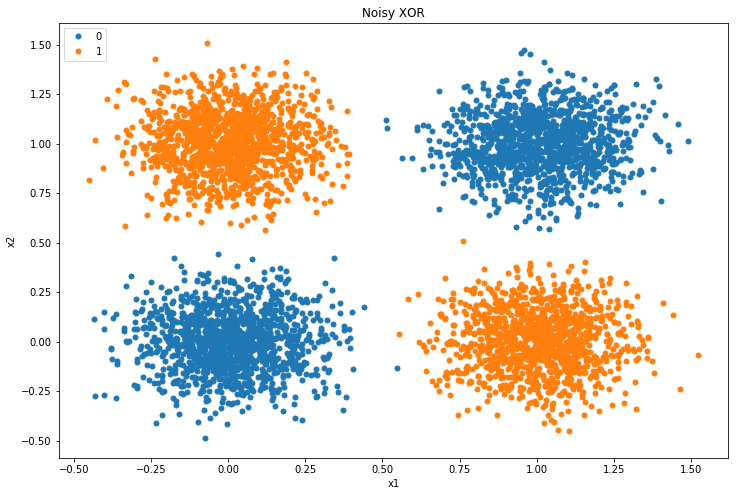

In [133]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [5]:
# Add a dimension for the bias
# X = np.c_[X, np.ones(X.shape[0])]

In [134]:
def next_batch(X, y, batch_size = 100):
    n = X.shape[0]
    idx = np.arange(n)
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    return X[idx, :], y[idx, :]

In [135]:
def relu(a):
    a[a < 0] = 0
    return a

def leaky_relu(a, eps):
    a[np.where(a < 0)] *= eps
    return a

In [136]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [137]:
def softplus(data, labels, a):
    loss = np.multiply(1 - 2*labels, a)
    loss = np.log(1 + np.exp(loss))
    return loss

In [138]:
class Network():
    def __init__(self, hidden_units = 3, lr = 0.1,
                 batch_size = 100, debug = False):

        # Network specifications
        self.hidden_units = hidden_units
        self.batch_size = batch_size
        self.lr = lr
        self.debug = debug
        
        # Initialize network parameters
        w1 = np.random.rand(hidden_units, X.shape[1]) - 0.5
        w2 = np.random.rand(y.shape[1], hidden_units) - 0.5
        b1 = np.zeros((hidden_units, 1))
        b2 = np.zeros((y.shape[1], 1))
        
        self.weights = [w1, w2]
        self.bias = [b1, b2]
        
        # Initialize batchwise layer outputs as empty
        self.linear1 = []
        self.relu1 = []
        self.eps = 0.01
        self.linear2 = []
        
        # Initialize batchwise gradients as empty
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
    
    # Feedforward for entire batch
    def forward(self, data):
        self.linear1 = []
        self.relu1 = []
        self.linear2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::].T
            self._forward(x, idx)
        return np.array(self.linear2)
    
    # Feedforward for a single data point
    def _forward(self, x, idx):
        linear1 = np.dot(self.weights[0], x) + self.bias[0]
        relu1 = leaky_relu(linear1, self.eps)
        linear2 = np.dot(self.weights[1], relu1) + self.bias[1]
        
        self.linear1.append(linear1)
        self.relu1.append(relu1)
        self.linear2.append(linear2)
        
        if self.debug and idx == 0:
            print("\n---- PRINT FORWARD DATA ----\n")
            print("linear1 = ", linear1)
            print("relu1 = ", relu1)
            print("linear2 = ", linear2)
        
        return linear2
        
    # Backprop for entire batch
    def backward(self, L, data, labels):
        if (data.shape[0] != labels.shape[0]):
            print("Data and labels shapes mismatch")
            return None
        
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::].T
            y = labels[idx]
            self._backward(L, x, y, idx)

        self.grad_weights = [np.mean(self.allgrad_weight1),
                             np.mean(self.allgrad_weight2)]
        self.grad_bias = [np.mean(self.allgrad_bias1),
                          np.mean(self.allgrad_bias2)]
        
    # Backprop for a single data point
    def _backward(self, L, x, y, idx):
        r = 1.0 - 2*y
        grad_bias2 = sigmoid(r * self.linear2[idx]) * r
        grad_weight2 = np.multiply(grad_bias2, self.relu1[idx])
        grad_relu1 = grad_bias2 * self.weights[1]
        grad_linear1 = grad_relu1.T
        grad_linear1[np.where(self.relu1[idx] <= 0)] *= self.eps
        grad_weight1 = np.dot(grad_linear1, x.T)
        grad_bias1 = grad_linear1
            
        self.allgrad_weight1.append(grad_weight1)
        self.allgrad_weight2.append(grad_weight2)
        self.allgrad_bias1.append(grad_bias1)
        self.allgrad_bias2.append(grad_bias2)
        
        if (self.debug and idx == 0):
            print("\n---- PRINT BACKWARD DATA ----\n")
            print("linear2 = ", self.linear2[idx])
            print("r:", r, "y:", y)
            print("weight2:", self.weights[1])
            print("grad_bias2:", grad_bias2)
            print("grad_weight2:", grad_weight2)
            print("weight1:", self.weights[0])
            print("grad_relu1:", grad_relu1)
            print("grad_linear1:", grad_linear1)
            print("grad_weight1:", grad_weight1)
            print("grad_bias1:", grad_bias1)
    
    # Update mini batch weights
    def update_weights(self):
        self.weights[0] -= (self.lr * self.grad_weights[0])
        self.weights[1] -= (self.lr * self.grad_weights[1])
        self.bias[0] -= (self.lr * self.grad_bias[0])
        self.bias[1] -= (self.lr * self.grad_bias[1])
        
    # Predict labels
    def predict(self, data):
        out = self.forward(data)
        out[out >= 0] = 1
        out[out < 0] = 0
        return out
    
    # Compute accuracy
    def accuracy(self, data, labels):
        predicted_labels = self.predict(data).reshape(-1, 1)
        matches = np.where(predicted_labels == labels)
        return np.sum(labels == predicted_labels) / labels.shape[0] * 100.0

In [139]:
# Split indexes for training and testing
def split_data():
    train_n = X.shape[0]
    test_n = batch_size * 5
    train_n = train_n - test_n
    train_idx = np.arange(train_n)
    test_idx = np.arange(train_n, train_n + test_n)
    print("Split (train/test): (%d/%d)" %(train_n, test_n))
    data, labels = X[train_idx, ::], y[train_idx, ::]
    test_data, test_labels = X[test_idx, ::], y[test_idx, ::]
    return data, labels, test_data, test_labels

In [140]:
# Train an epoch
def train(net, epoch, data, labels, debug = False):
    train_n = data.shape[0]
    train_idx = np.arange(train_n)
    np.random.shuffle(train_idx)
    
    train_loss = []
    train_acc = []
    for i in range(0, train_n, batch_size):
        batch_idx = train_idx[i:i + batch_size]
        batch_X = data[batch_idx, ::]
        batch_y = labels[batch_idx, ::]
        
        # Feedforward
        a = net.forward(batch_X)
        loss = softplus(batch_X, batch_y, a.reshape(batch_size, 1))
        train_loss.append(loss)
        acc = net.accuracy(batch_X, batch_y)
        train_acc.append(acc)
        net.backward(loss, batch_X, batch_y)
        net.update_weights()
    
    if debug:
        print("Epoch %d, Train loss: %.4f" %(epoch, np.mean(train_loss)))
        print("Epoch %d, Train Accuracy: %.4f" %(epoch, np.mean(train_acc)))

In [141]:
# Test validation data
def test(net, test_data, test_labels, debug = True):
    test_n = test_data.shape[0]
    test_idx = np.arange(test_n)
    test_loss = []
    test_acc = []
    for i in range(0, test_n, batch_size):
        batch_idx = test_idx[i:i + batch_size]
        batch_X = test_data[batch_idx, :]
        batch_y = y[batch_idx, ::]
        a = net.forward(batch_X)
        loss = softplus(batch_X, batch_y, a.reshape(batch_size, 1))
        test_loss.append(loss)
        acc = net3.accuracy(batch_X, batch_y)
        test_acc.append(acc)
        if debug:
            print("Batch %d: %d/%d Accuracy: %f" %(i/batch_size, i, test_n, acc))    

    if debug:
        print("Test loss:", np.mean(test_loss))
        print("Accuracy:", np.mean(test_acc))

In [145]:
# Define decision boundary
def plot_boundary(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#     y_predict = y_prob
    indices_0 = np.where(y_prob == 0)
    indices_1 = np.where(y_prob == 1)
#     indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
#     indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Network with 3 hidden units, Accuracy: 91.6%

In [143]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
# seed = 7930
# seed = 3226
# seed = 8641
# seed = 422
# seed = 1967
seed = 2509
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 20
hidden_units = 3

# Initialize network
net3 = Network(hidden_units = 3, lr = 0.001, 
              batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data()

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net3, epoch, data, labels, debug = True)
    
test(net3, test_data, test_labels, debug = True)

Random seed: 2509
Split (train/test): (4750/250)
Epoch 0, Train loss: 0.6887
Epoch 0, Train Accuracy: 44.5895
Epoch 1, Train loss: 0.6886
Epoch 1, Train Accuracy: 43.6211
Epoch 2, Train loss: 0.6886
Epoch 2, Train Accuracy: 42.5263
Epoch 3, Train loss: 0.6885
Epoch 3, Train Accuracy: 41.4316
Epoch 4, Train loss: 0.6884
Epoch 4, Train Accuracy: 40.8000
Epoch 5, Train loss: 0.6884
Epoch 5, Train Accuracy: 40.8211
Epoch 6, Train loss: 0.6883
Epoch 6, Train Accuracy: 40.9895
Epoch 7, Train loss: 0.6882
Epoch 7, Train Accuracy: 40.9053
Epoch 8, Train loss: 0.6882
Epoch 8, Train Accuracy: 40.8421
Epoch 9, Train loss: 0.6881
Epoch 9, Train Accuracy: 40.9895
Epoch 10, Train loss: 0.6880
Epoch 10, Train Accuracy: 41.0105
Epoch 11, Train loss: 0.6880
Epoch 11, Train Accuracy: 41.1158
Epoch 12, Train loss: 0.6879
Epoch 12, Train Accuracy: 41.1789
Epoch 13, Train loss: 0.6878
Epoch 13, Train Accuracy: 41.4737
Epoch 14, Train loss: 0.6877
Epoch 14, Train Accuracy: 41.9368
Epoch 15, Train loss: 0.68

In [ ]:
n = 1000
new_X = np.random.uniform(-0.5, 1.5, (n, 2))
new_y = net3.predict(new_X)
plot_boundary(new_X, new_y)

In [122]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
# seed = 7930
# seed = 3226
# seed = 1967
seed = 4158
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 20
hidden_units = 3

# Initialize network
net16 = Network(hidden_units = 16, lr = 0.005, 
              batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data()

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net16, epoch, data, labels, debug = True)
    
test(net16, test_data, test_labels, debug = True)

Random seed: 4158
Split (train/test): (9750/250)


ValueError: cannot reshape array of size 800 into shape (50,1)